remove more unnecessary variables from the dataset

In [6]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import tensorflow as tf
import keras
from keras import layers
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
df = pd.read_csv("../datasets/Task_2/4.csv")
df.drop(['ID'],axis=1,inplace=True)

In [ ]:
corr_matrix = df.corr()['Segmentation']
corr_matrix.sort_values(ascending=False)
# => Remove everything below .1 correlation  


Segmentation            1.000000
Ever_Married            0.400718
Profession_Artist       0.383292
Spending_Score          0.365599
Age                     0.355099
Graduated               0.352733
Var_1                   0.117140
Profession_Executive    0.068042
Gender                  0.037682
Profession_Lawyer       0.016695
Name: Segmentation, dtype: float64

In [8]:
removables = ['Profession_Lawyer', 'Gender', 'Profession_Executive']
df = df.drop(removables, axis=1)

In [9]:
df.to_csv("../datasets/Task_2/5.csv")

In [10]:
# let's assign actual names for the Segmentation Classes
# so we have nicer metrics and results later (after training model)
df['Segmentation'] = df['Segmentation'].replace({
    1: "1: A",
    2: "2: B",
    3: "3: C",
    4: "4: D"
})


In [11]:
# everything else except the target variable
X = df.drop("Segmentation", axis=1)

# have only the target variable here (dependent variable)
y_temp = df['Segmentation']

# since we are doing classification, we have to process our target values with an encoder
# and convert them into a categorical TensorFlow/Keras -format 
le = LabelEncoder()
y_enc = le.fit_transform(y_temp)

# Converting the label into a matrix form
y = tf.keras.utils.to_categorical(y_enc)

# save the categories into a helper list for later purposes
categories = list(le.classes_)
categories

['1: A', '2: B', '3: C', '4: D']

In [12]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# convert all continuous variables to integer,
# and convert all negative numbers to 0
X_cat = X.astype(int)
X_cat = X_cat.clip(lower=0)

chi_2_features = SelectKBest(chi2, k=len(X_cat.columns))
best_features = chi_2_features.fit(X_cat,y.astype(int))
pd.options.display.float_format = '{:.2f}'.format

# the higher the score, the more effect that column has on price
df_features = pd.DataFrame(best_features.scores_)
df_columns = pd.DataFrame(X_cat.columns)
f_scores = pd.concat([df_columns,df_features],axis=1)
f_scores.columns = ['Features','Score']
f_scores.sort_values(by='Score',ascending=False)
# Gender, Profession and Var_1 have basically no effect

,Features,Score
1,Age,7204.87
5,Profession_Artist,763.56
0,Ever_Married,542.33
2,Graduated,370.29
3,Spending_Score,359.52
4,Var_1,42.23


In [13]:
# this time, let's split the data into 65% (training data) and 35% (temporary data)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.35)

# step 2, split the temporary data in HALF (0.5) => 17.5% test and 17.5% validation
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

In [14]:
# Define Sequential neural network model
# modify the input shape to match your training column count
# remember, one of the columns is removed from training columns
# to be the target value. so if your data originally had 10 columns
# the input shape is 9 ... (10 - 1 => 9)
# the input layer itself can have a different number of nodes
# Tip: have at least the same number of nodes as in the input shape
# output layer in classification depends on amount of output options in target variable
model = keras.Sequential(
    [
        layers.BatchNormalization(input_shape=(len(X.columns),)),
        layers.Dense(16, activation="relu", kernel_regularizer=keras.regularizers.l1(l1=0.1)),
        layers.Dense(8, activation="relu"),
        layers.Dense(len(categories), activation="softmax")
    ]
)

# compile the model, this time we use categorical crossentropy for loss -function
# and we also measure the accuracy of our model in the metrics
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/home/lukas/dev/venvs/DL/lib/python3.12/site-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-10-10 23:40:09.697338: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 6)              │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │            36 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 308 (1.20 KB)

 Trainable params: 296 (1.16 KB)

 Non-trainable params: 12 (48.00 B)

In [15]:
model.fit(x=X_train, y=y_train, epochs=300, validation_data=(X_val, y_val))

Epoch 1/300
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2416 - loss: 3.5680 - val_accuracy: 0.2783 - val_loss: 2.8943
Epoch 2/300
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3749 - loss: 2.3885 - val_accuracy: 0.3838 - val_loss: 1.9514
Epoch 3/300
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3905 - loss: 1.6520 - val_accuracy: 0.3685 - val_loss: 1.4316
Epoch 4/300
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3961 - loss: 1.3661 - val_accuracy: 0.4159 - val_loss: 1.3292
Epoch 5/300
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4296 - loss: 1.3167 - val_accuracy: 0.4113 - val_loss: 1.2939
Epoch 6/300
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4358 - loss: 1.2905 - val_accuracy: 0.4442 - val_loss: 1.2700
Epoch 7/300
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4488 - loss: 1.2681 - val_accuracy: 0.4365 - val_loss: 1.2550
Epoch 8/300
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4438 - loss: 1.2576 - val_accu

<Axes: >

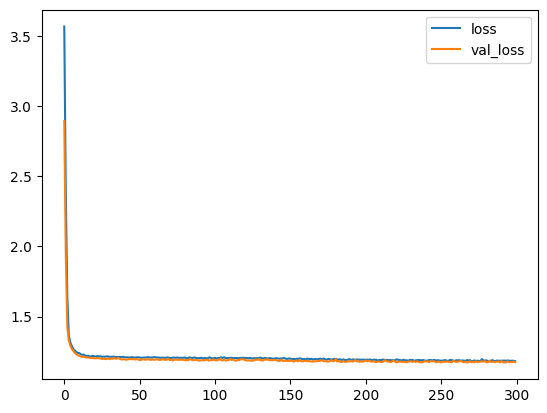

In [16]:
loss_df = pd.DataFrame(model.history.history)
loss_df[['loss', 'val_loss']].plot()


<Axes: >

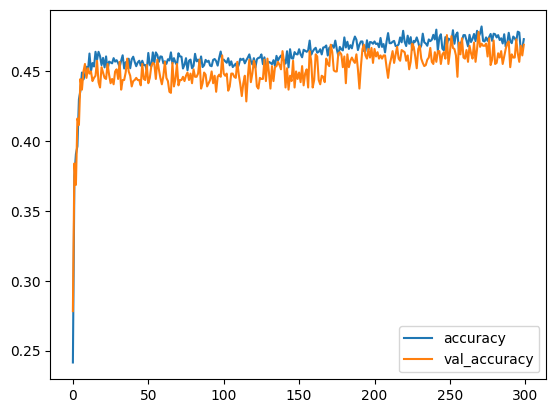

In [17]:
# For Accuracy and val_accuracy there is still a bit of room for improvement with values of ~65%  
loss_df[['accuracy', 'val_accuracy']].plot()

In [18]:
# compare the final model loss/accuracy/evaluation values
# the values should again match mostly

# => the values almost match 
print("Test data evaluation:")
print(model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(X_train, y_train, verbose=0))

Test data evaluation:
[1.1605291366577148, 0.4774637222290039]

Train data evaluation:
[1.1713863611221313, 0.48086419701576233]


In [19]:
# get predictions and convert with argmax() to get categories 
# instead of raw probabilities
test_predictions = model.predict(X_test)
test_predictions = np.argmax(test_predictions, axis=1)

# convert also y-test -values with argmax
y_test = np.argmax(y_test, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
print(classification_report(y_test, test_predictions, target_names=categories))
acc = accuracy_score(y_test, test_predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

# this worsened model performance

              precision    recall  f1-score   support

        1: A       0.60      0.73      0.66       372
        2: B       0.34      0.35      0.35       299
        3: C       0.42      0.18      0.25       324
        4: D       0.47      0.61      0.53       314

    accuracy                           0.48      1309
   macro avg       0.46      0.47      0.45      1309
weighted avg       0.46      0.48      0.45      1309


Model overall accuracy: 47.75%


In [21]:
# In multi category classification , AUC values are often interpreted as follows: 
# 0.5-0.6 (failed)
# 0.6-0.7 (worthless)
# 0.7-0.8 (poor)
# 0.8-0.9 (good)
# > 0.9 (excellent)

# get ROC-AUC -score
roc_auc_score(y, model.predict(X), multi_class="ovr")
#=> .78 performs poor

234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step


0.7367616342325224

### Analysis:
This step worsened model performance
